In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import celltypist

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.set_figure_params(dpi=80)

# Variables

In [5]:
adata_dir = '/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/subsets'
sample_id = 'HEA_FOET14880396'
celltype = 'Neurons'

In [6]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Read in data

In [7]:
# read in
adata = sc.read_h5ad(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')
adata

AnnData object with n_obs × n_vars = 589 × 14494
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_1', 'leiden_1.2', 'leiden_1.5', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_coarse2midmod_colors', 'celltypist_coar

# Remove mid-grain markers from the feature

In [8]:
# read in
midgrain_markers = pd.read_csv('/nfs/team205/kk18/notebooks/Foetal/VisiumHD/re-seq_mpp0p3/sc_midgrain_markers.csv',
                               index_col=0
                              )
# remove the markers of celltype of interest
midgrain_markers = midgrain_markers[midgrain_markers['group']!=celltype]
midgrain_markers

group   names      scores  logfoldchanges  pvals  \
0       AtrialCardiomyocytes    MYH6  589.180000        8.461190    0.0   
1       AtrialCardiomyocytes     PAM  446.767100        5.372062    0.0   
2       AtrialCardiomyocytes    NPPA  444.359400        7.048445    0.0   
3       AtrialCardiomyocytes    MYL7  444.032530        5.999820    0.0   
4       AtrialCardiomyocytes   TNNT2  428.842380        4.739163    0.0   
...                      ...     ...         ...             ...    ...   
102668         LymphoidCells     ADK   54.743217        1.088896    0.0   
102770         LymphoidCells  FCHSD2   51.053140        1.119463    0.0   
102785         LymphoidCells   SPIDR   50.689087        1.023158    0.0   
102788         LymphoidCells  IMMP2L   50.527325        1.016055    0.0   
102906         LymphoidCells  RAD51B   47.156956        1.018748    0.0   

        pvals_adj  group_mean  
0             0.0    3.555969  
1             0.0    4.026159  
2             0.0    4.366144  
3             0.0    4.489749  
4             0.0    3.264460  
...           ...         ...  
102668        0.0    1.117559  
102770        0.0    1.309117  
102785        0.0    1.011237  
102788        0.0    1.424370  
102906        0.0    1.072148  

[2445 rows x 7 columns]

In [9]:
# remove
mask = [x not in list(midgrain_markers['names']) for x in adata.var_names]
bdata = adata[:,mask]
bdata

View of AnnData object with n_obs × n_vars = 589 × 13304
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'leiden_0.2', 'leiden_0.4', 'leiden_0.6', 'leiden_1', 'leiden_1.2', 'leiden_1.5', 'leiden_2'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltypist_coarse2midmod_colors', 'celltyp

# PCA, Clustering, UMAP

number of hvgs: 3519


/software/cellgen/team205/kk18/envs/generic_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


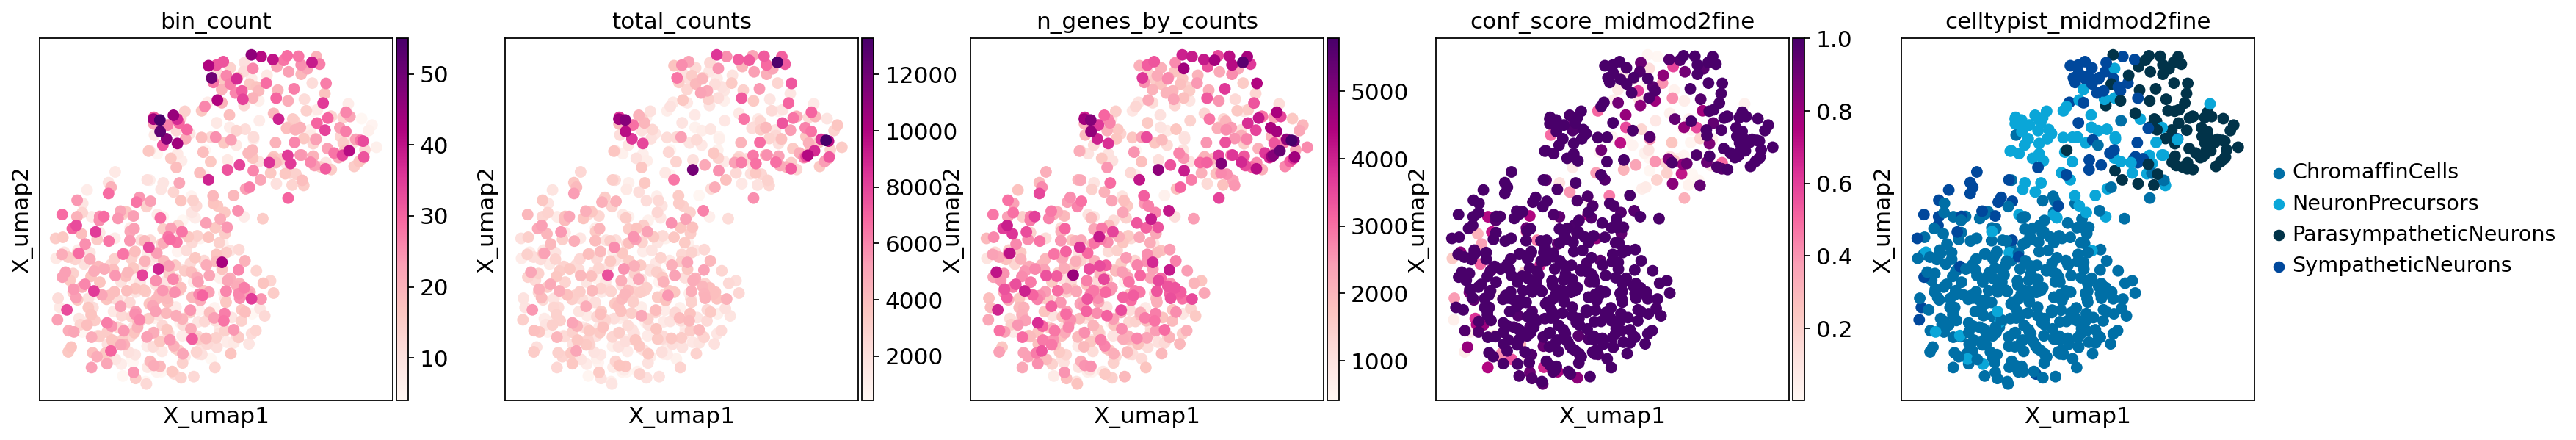

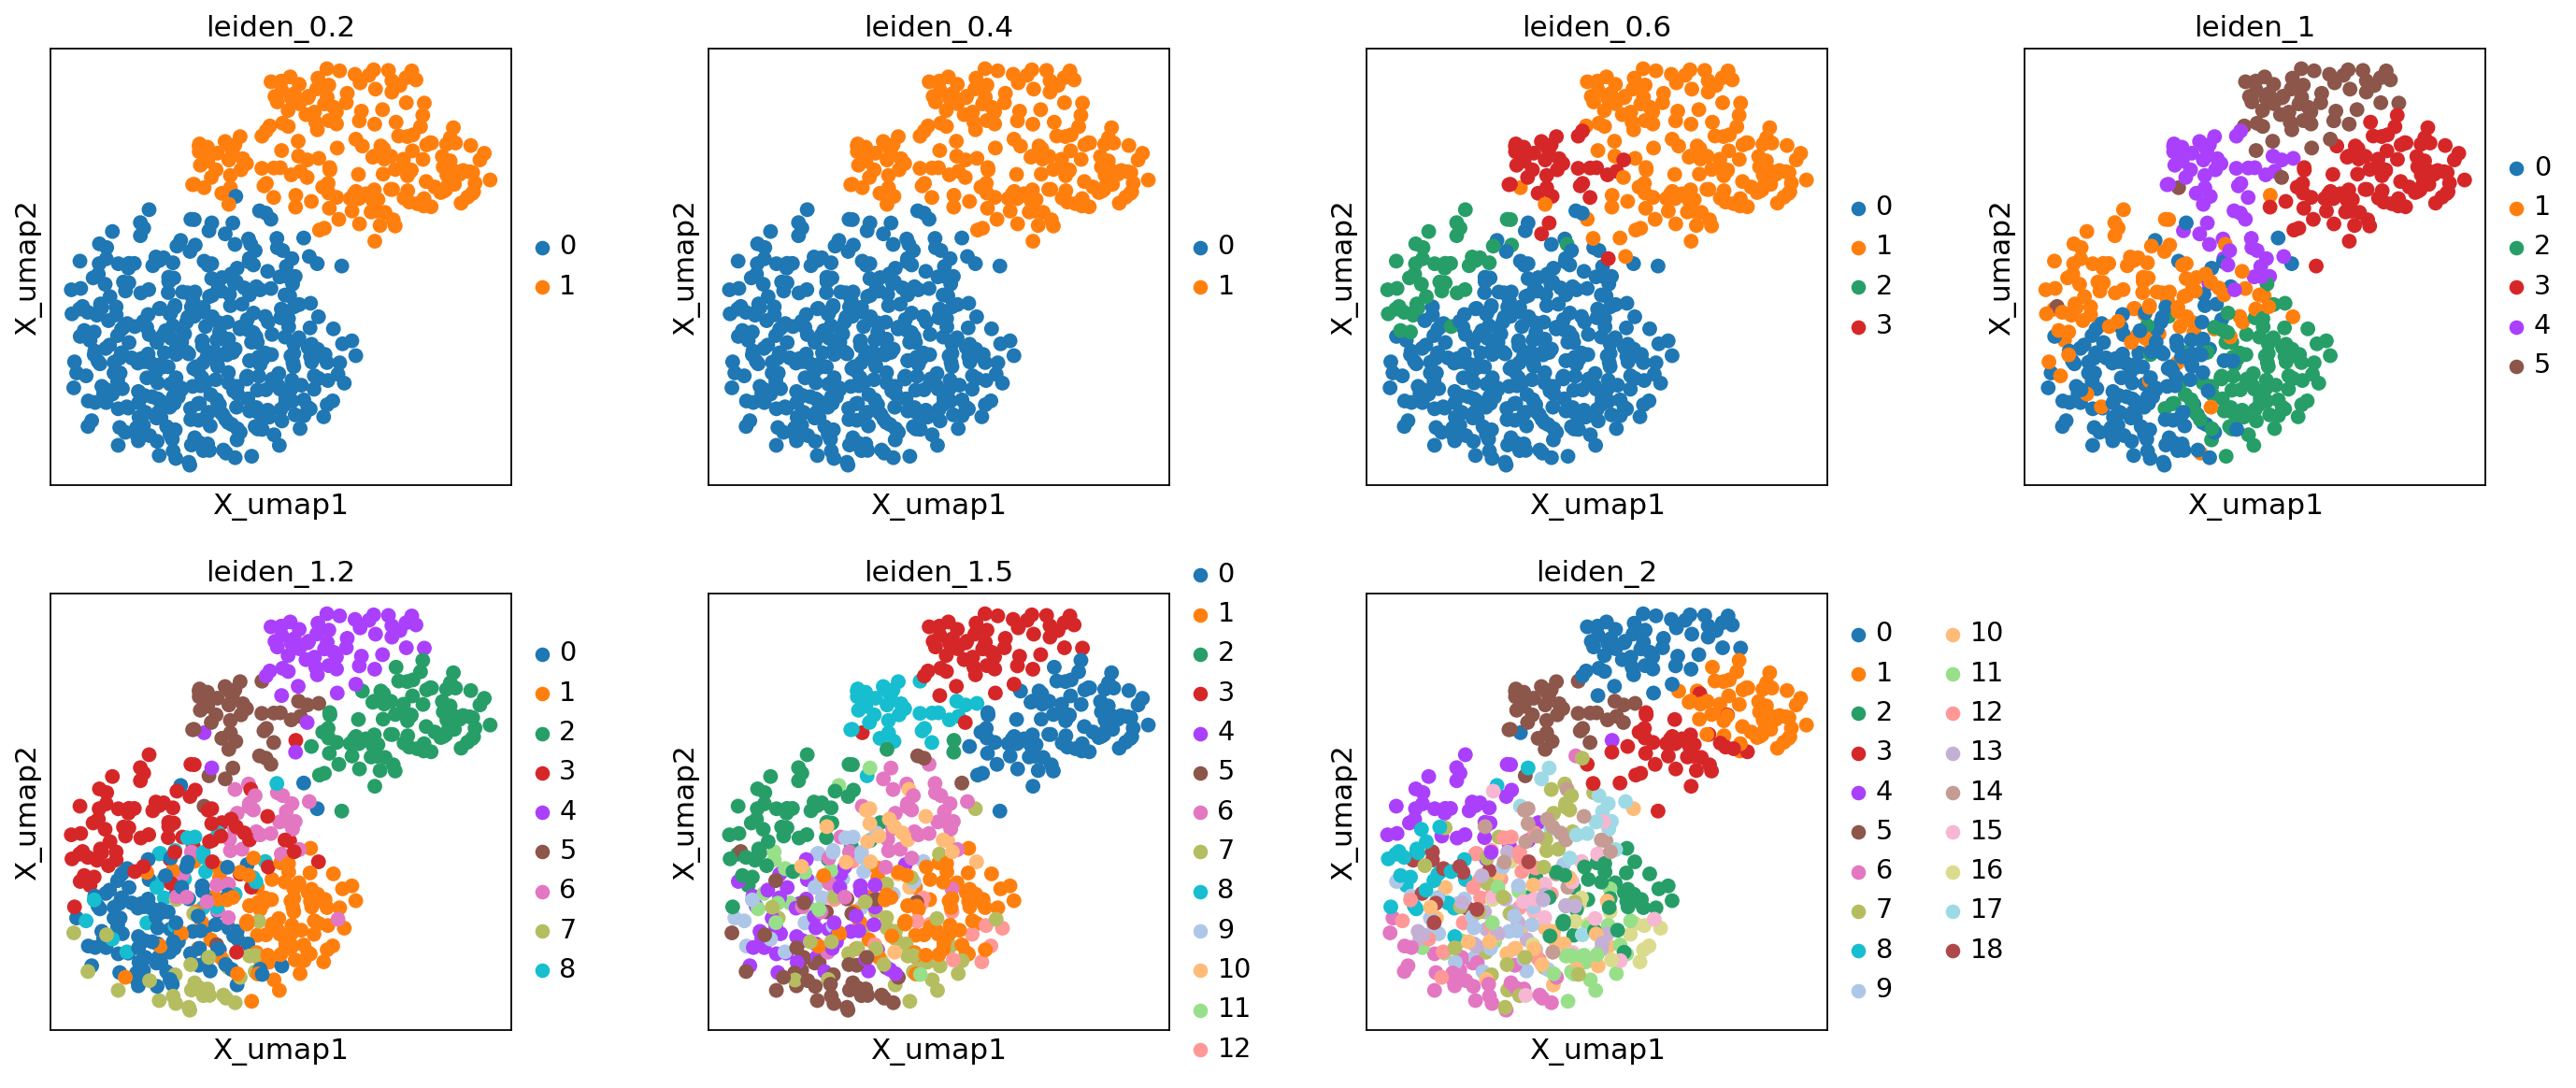

In [10]:
# HVGs, using the object which doesn't have midgrain markers
sc.pp.highly_variable_genes(bdata, flavor='seurat', min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f'number of hvgs: {sum(bdata.var.highly_variable)}')
# PCA using the degected HVGs
sc.tl.pca(bdata, use_highly_variable=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
# create neighbour graph
sc.pp.neighbors(adata,n_neighbors=15,use_rep='X_pca')
# visualisation with umap
sc.tl.umap(adata,min_dist=0.5)
sc.pl.embedding(adata,basis='X_umap',color=['bin_count','total_counts','n_genes_by_counts',"conf_score_midmod2fine","celltypist_midmod2fine",],
                wspace=0.2,cmap='RdPu',vmax='p100',ncols=5)
# leiden clustering
resolutions_list = [0.2,0.4,0.6,1,1.2,1.5,2]
for resolution in resolutions_list:
    sc.tl.leiden(adata,resolution=resolution,key_added=f'leiden_{str(resolution)}',n_iterations=2)
sc.pl.embedding(adata,basis='X_umap',
                color=[f'leiden_{str(resolution)}' for resolution in resolutions_list],
                wspace=0.3)

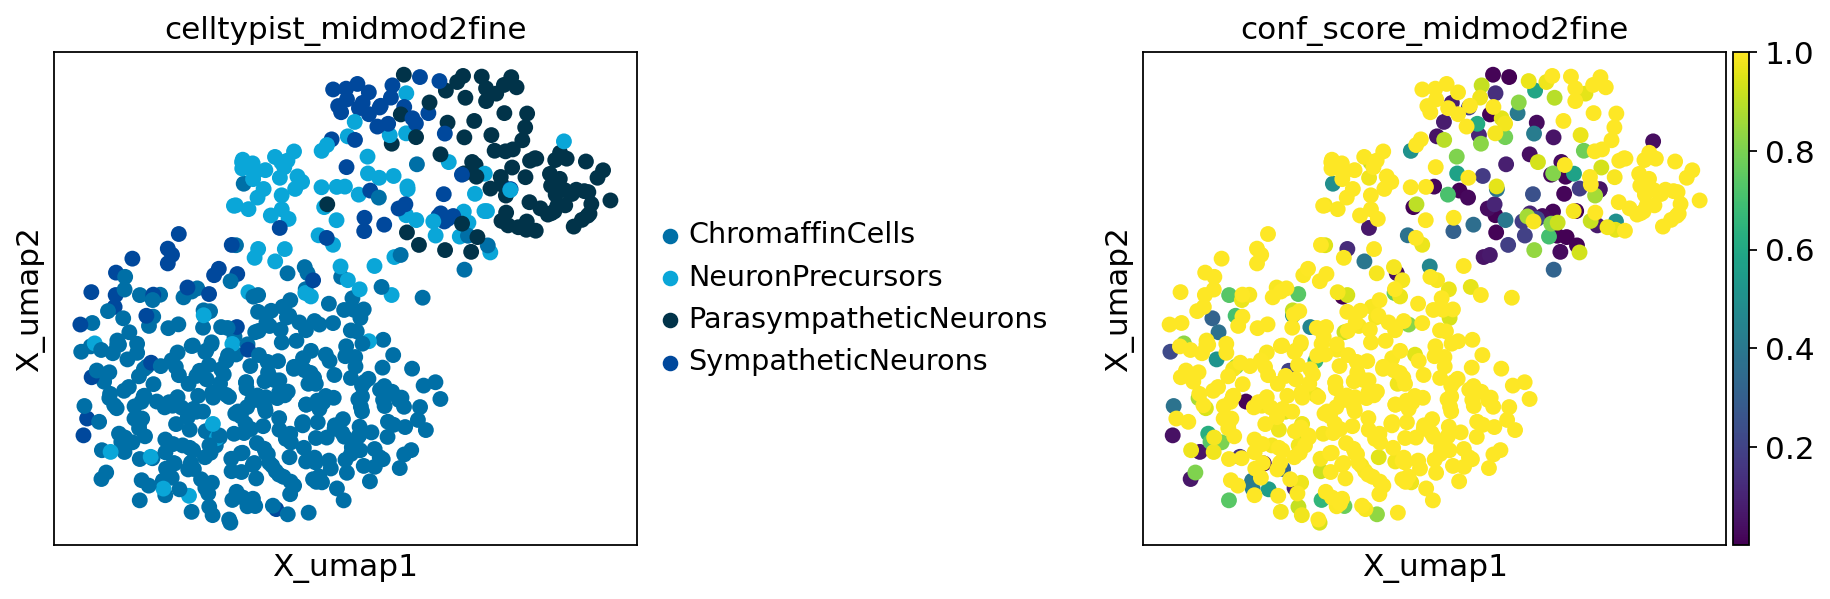

In [11]:
sc.pl.embedding(adata,basis='X_umap',
                color=['celltypist_midmod2fine', 'conf_score_midmod2fine'],
                wspace=0.7)

In [15]:
'SLC18A3' in adata.var_names

True

# Annotation

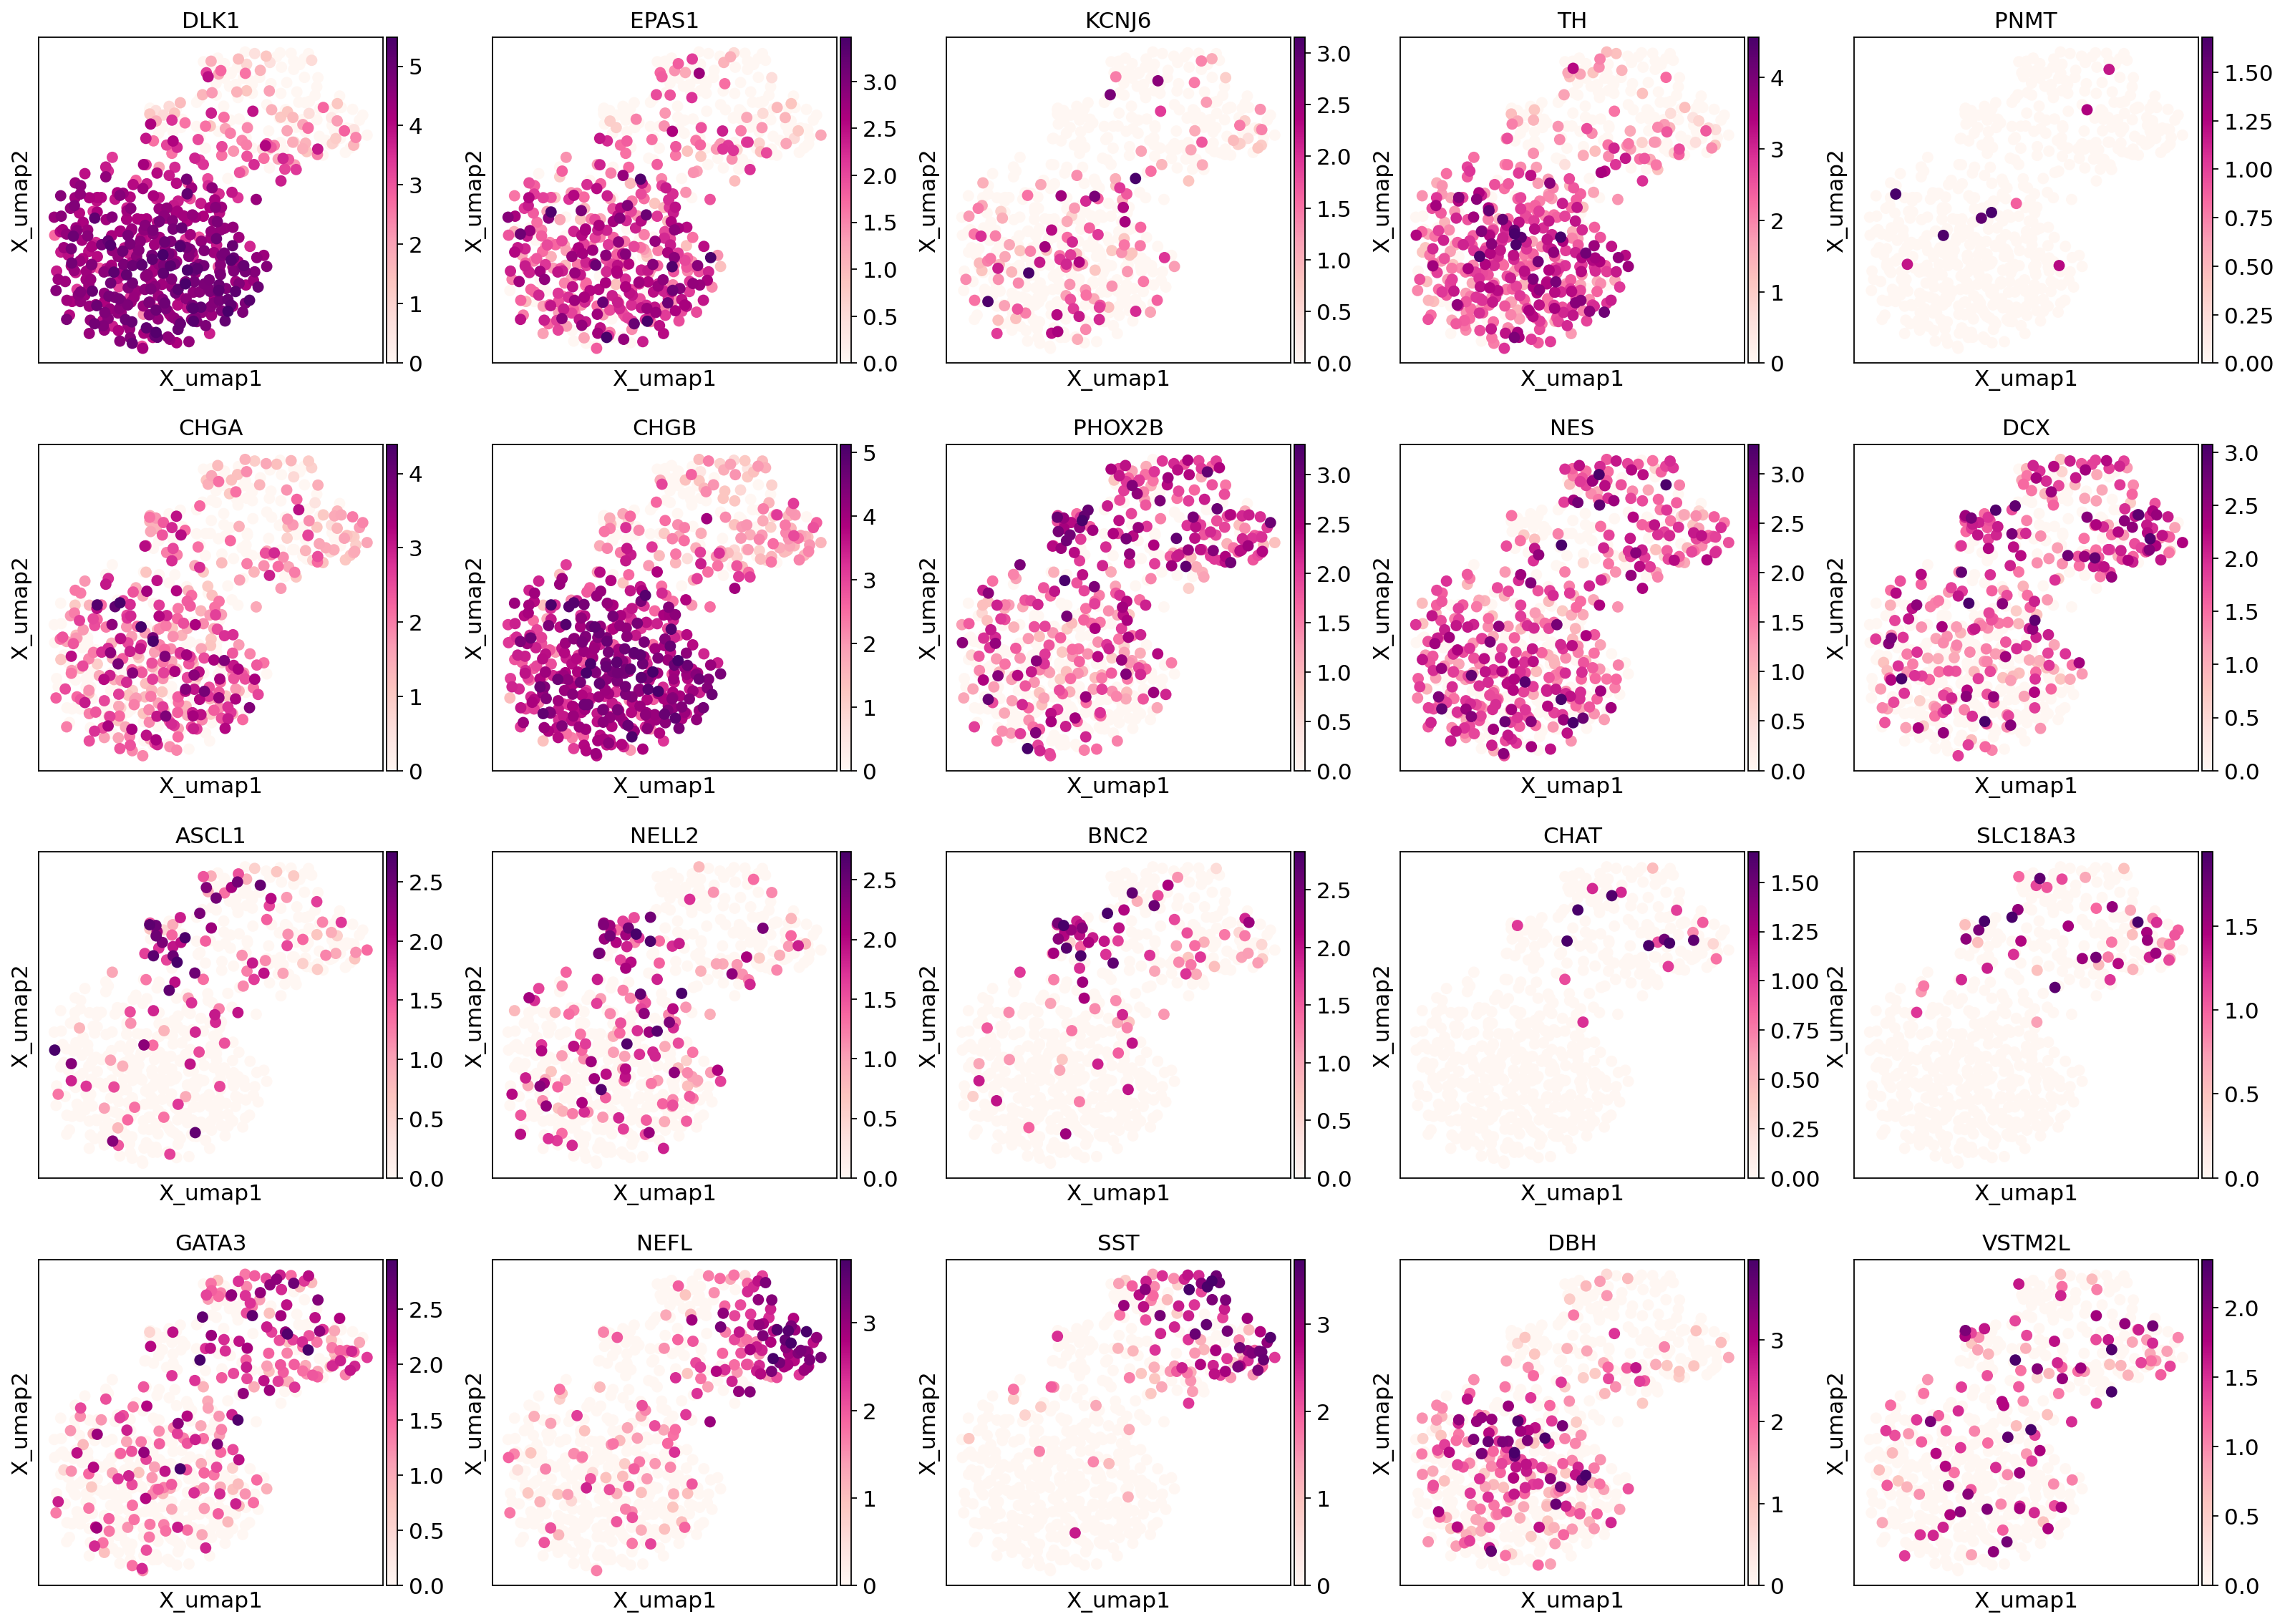

In [31]:
# markers for fine-grained cell types
markers = {
    "ChromaffinCells": [
        'DLK1',
        'EPAS1',
        'KCNJ6',
        "TH",    # Tyrosine hydroxylase
        "PNMT",  # Phenylethanolamine N-methyltransferase
        "CHGA",  # Chromogranin A
        "CHGB",  # Chromogranin B
        "PHOX2B"
    ],
    "NeuronPrecursors": [
        "NES",    # Nestin
        "PAX6",   # Paired box 6
        "TUBB3",  # Tubulin Beta 3 Class III
        "DCX",     # Doublecortin
        'ASCL1','NELL2','BNC2'
    ],
    "ParasympatheticNeurons": [
        "PHOX2B",
        "CHAT",    # Choline O-Acetyltransferase
        "SLC18A3", # Solute Carrier Family 18 Member A3 (Vesicular Acetylcholine Transporter)
        "GATA3",
        'NEFL','SST'
    ],
    "SympatheticNeurons": [
        "TH",
        "PHOX2B",
        "GATA3",
        "CHGA",
        "CHGB",
        'DBH','VSTM2L'
    ]
}

genes = []
for g in markers.values():
    genes = genes + [x for x in g if (x in adata.var_names)&(x not in genes)]
sc.pl.embedding(adata,basis='X_umap',color=genes,
               ncols=5, wspace=0.2,cmap='RdPu',vmax='p99.7')

In [16]:
resolution_sel = 1

categories: 0, 1, 2, etc.
var_group_labels: ChromaffinCells, NeuronPrecursors, ParasympatheticNeurons, etc.


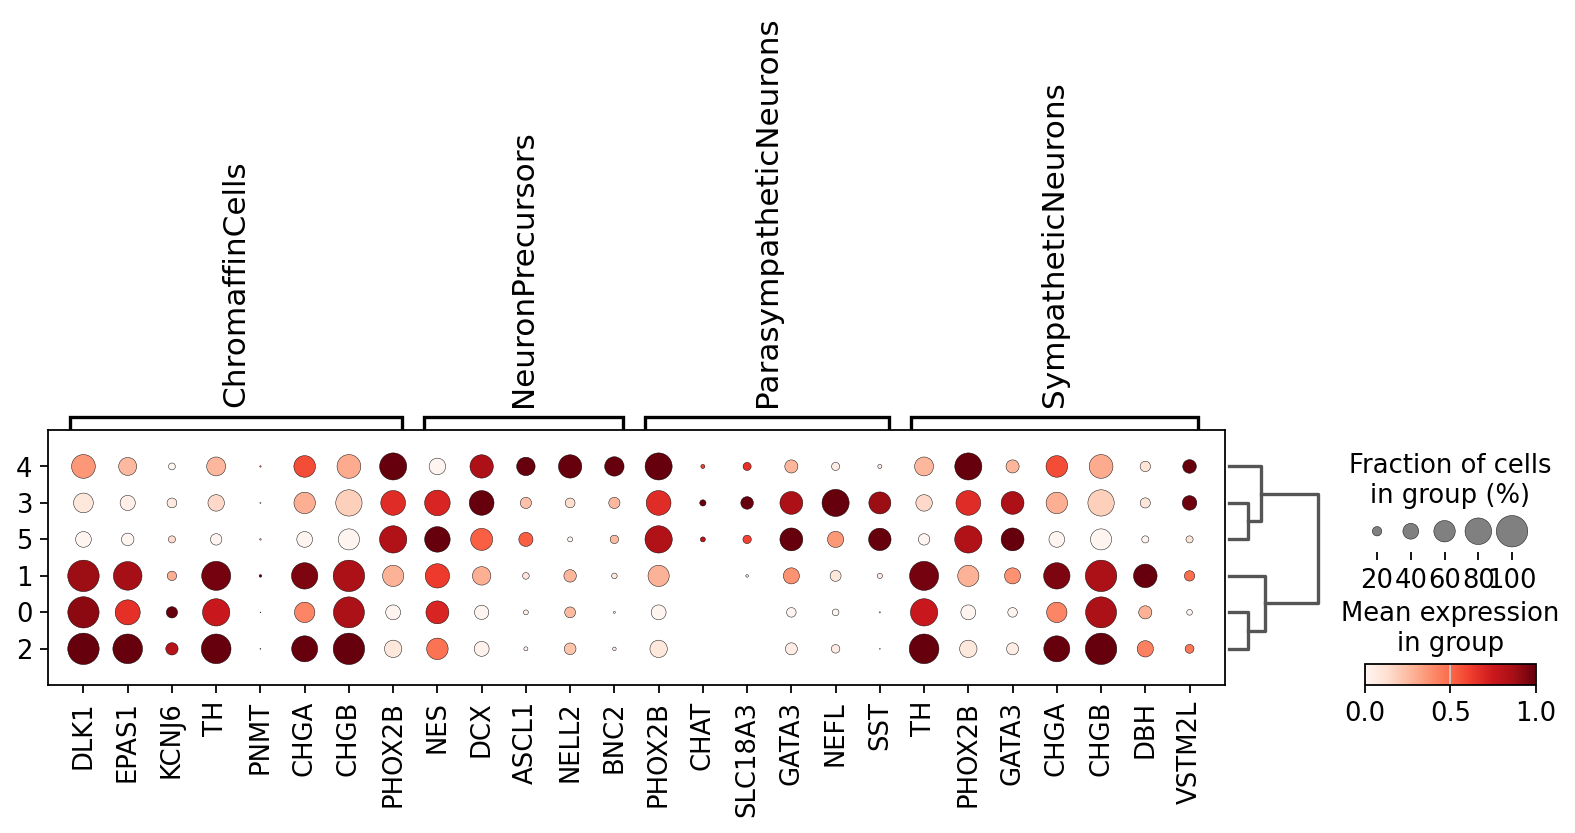

In [32]:
for key in markers.keys():
    markers[key]=[x for x in markers[key] if x in adata.var_names]

sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
sc.pl.dotplot(adata,
              markers, 
              groupby=f'leiden_{str(resolution_sel)}',
              dendrogram=True,
              standard_scale="var",
              color_map="Reds",
              swap_axes=False,
             )

[1.1620675  1.88821923 2.69821449 1.59010602 1.98053876]


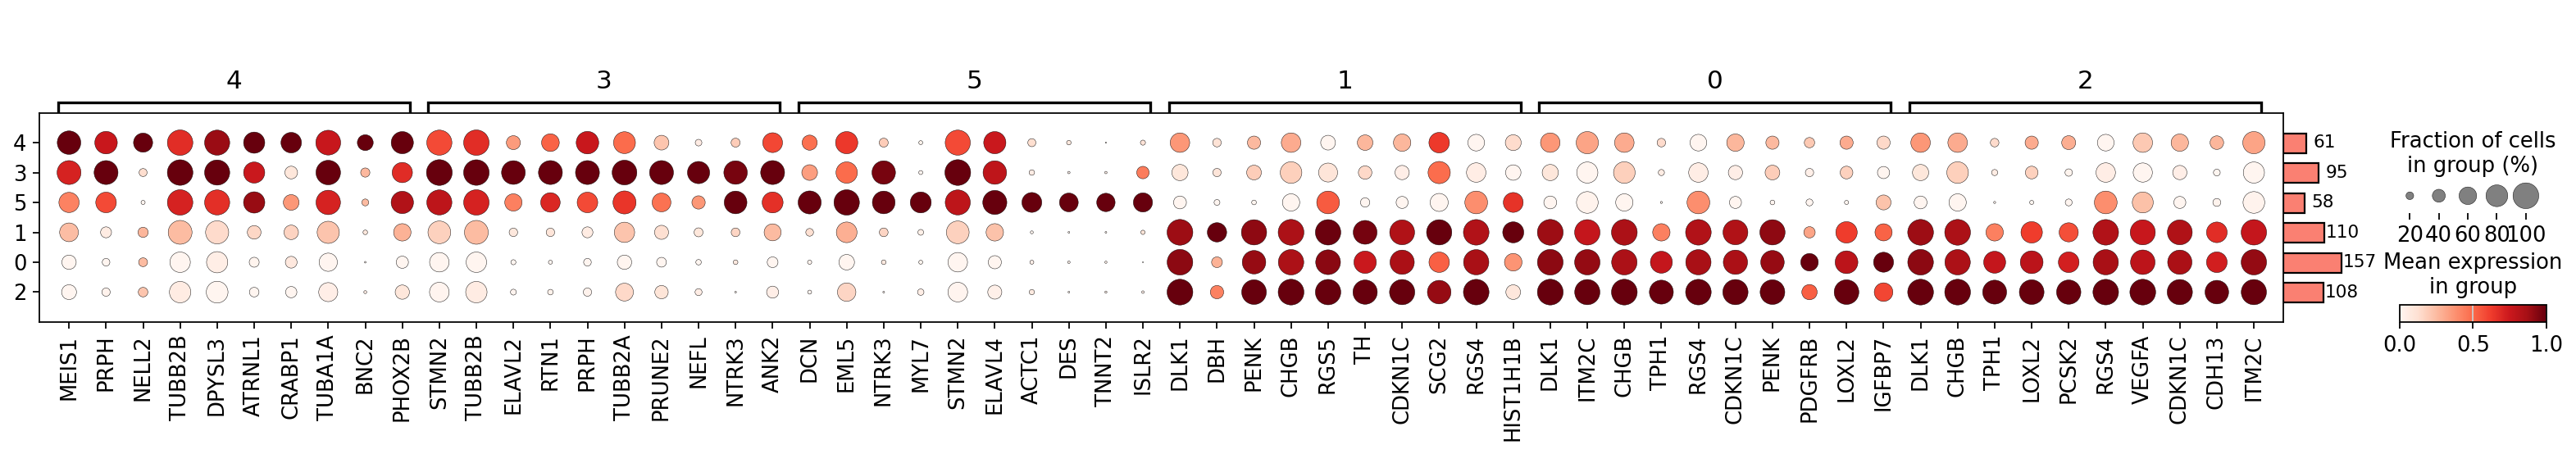

In [21]:
# DEG analysis
print(adata.X.data[:5])
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata,groupby=f'leiden_{str(resolution_sel)}')
sc.tl.dendrogram(adata, groupby=f'leiden_{str(resolution_sel)}')
dp=sc.pl.rank_genes_groups_dotplot(adata, dendrogram=True, standard_scale='var', return_fig=True)
dp.add_totals().show()

[1.1620675  1.88821923 2.69821449 1.59010602 2.22351621]


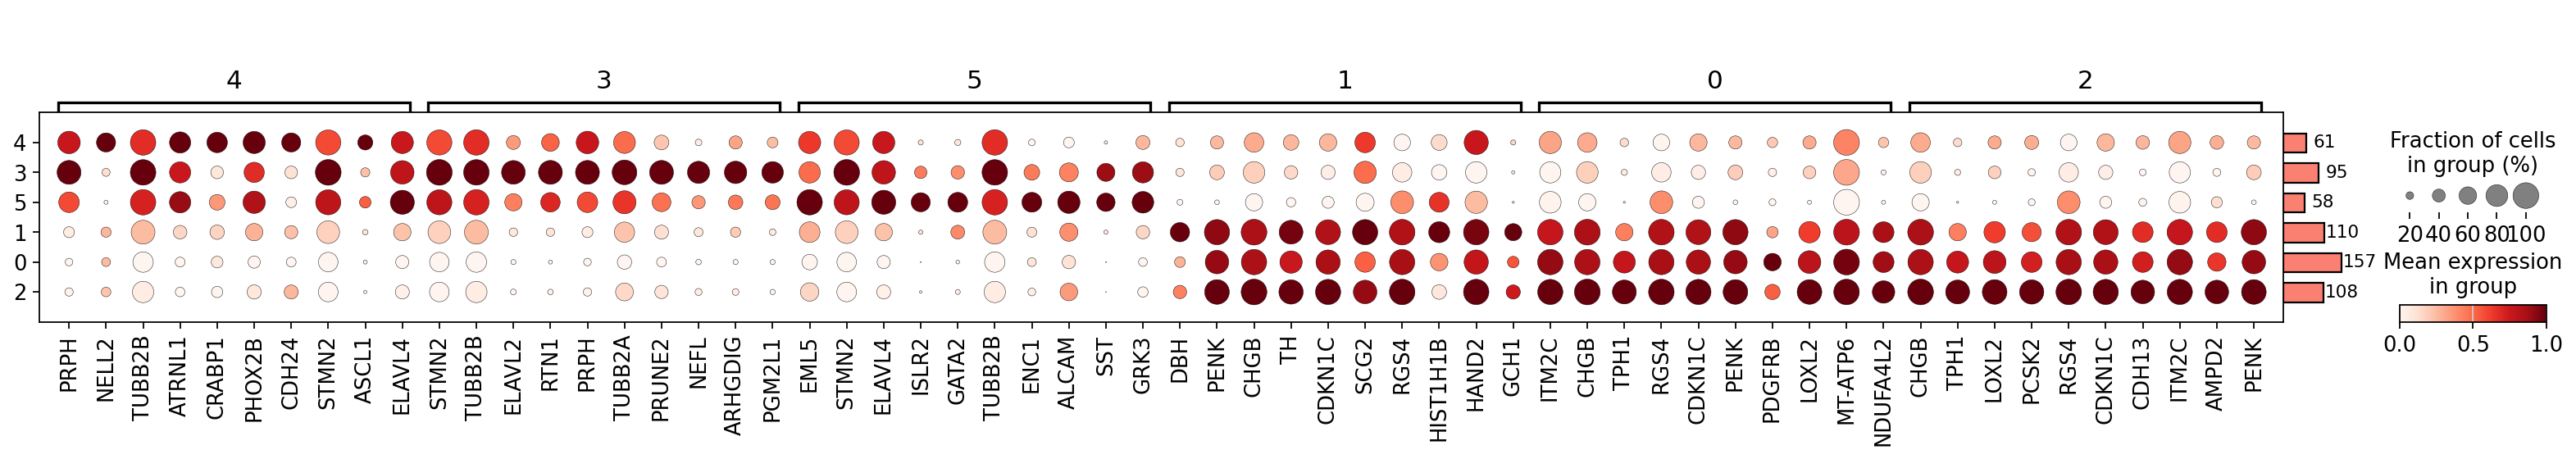

In [22]:
# DEG analysis without other cell type markers
# with removing mid_grain markers
# remove mid_grain markers
mask = [x not in list(midgrain_markers['names']) for x in adata.var_names]
bdata = adata[:,mask]

print(bdata.X.data[:5])
bdata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(bdata,groupby=f'leiden_{str(resolution_sel)}')
sc.tl.dendrogram(bdata, groupby=f'leiden_{str(resolution_sel)}')
dp=sc.pl.rank_genes_groups_dotplot(bdata, dendrogram=True, standard_scale='var', return_fig=True)
dp.add_totals().show()

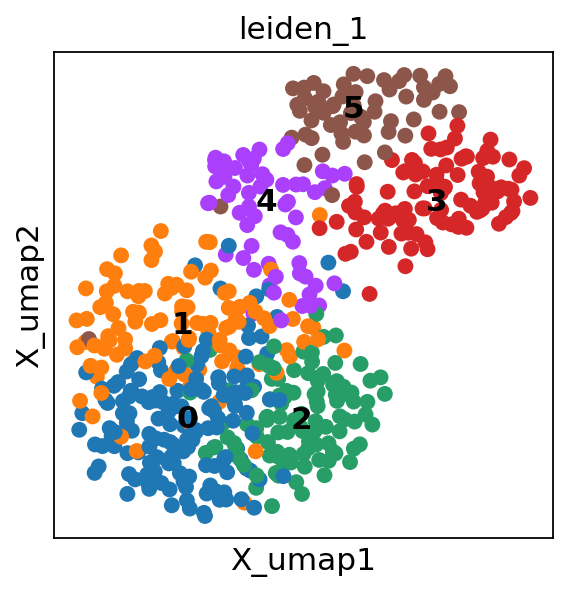

In [23]:
sc.pl.embedding(adata,basis='X_umap',
                color=f'leiden_{str(resolution_sel)}',
                wspace=0.3, legend_loc='on data')

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

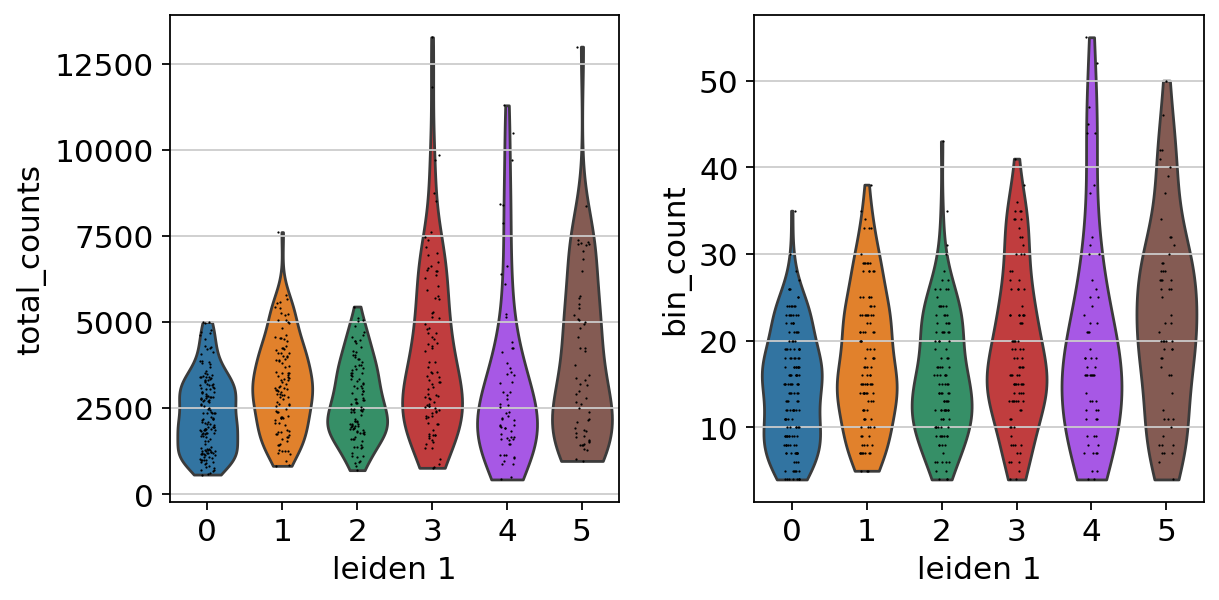

In [25]:
sc.pl.violin(adata,keys=['total_counts','bin_count'],groupby=f'leiden_{str(resolution_sel)}')

In [27]:
# annotate
adata.obs['fine_grain_manual'] = adata.obs[f'leiden_{str(resolution_sel)}'].copy()
adata.obs.replace({'fine_grain_manual':{
    '0':'ChromaffinCells',
    '1':'SympatheticNeurons',
    '2':'ChromaffinCells',
    '3':'ParasympatheticNeurons',
    '4':'NeuronPrecursors',
     '5':'ParasympatheticNeurons',
}},inplace=True)
adata.obs['fine_grain_manual'].value_counts()

fine_grain_manual
ChromaffinCells           265
ParasympatheticNeurons    153
SympatheticNeurons        110
NeuronPrecursors           61
Name: count, dtype: int64

In [26]:
ad = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw_finegrain_updated.h5ad',backed='r')
set(ad.obs['fine_grain'])

{'AtrialCardiomyocytesCycling',
 'AtrialCardiomyocytesLeft',
 'AtrialCardiomyocytesRight',
 'AtrioventricularNodePacemakerCells',
 'BCells',
 'BCellsMS4A1pos',
 'ChromaffinCells',
 'CoronaryArterialEndothelialCells',
 'CoronaryCapillaryEndothelialCells',
 'CoronaryPericytes',
 'CoronarySmoothMuscleCells',
 'CoronaryVenousEndothelialCells',
 'CoronaryVesselAdventitialFibroblasts',
 'DendriticCellsMature',
 'DendriticCellsType1',
 'DuctusArteriosusSmoothMuscleCells',
 'EndocardialCells',
 'EndocardialCushionCells',
 'EpicardiumDerivedCells',
 'GreatVesselAdventitialFibroblasts',
 'GreatVesselArterialEndothelialCells',
 'GreatVesselSmoothMuscleCells',
 'GreatVesselVenousEndothelialCells',
 'InnateLymphoidCells',
 'LymphNodeFibroblasticReticularCells',
 'LymphaticEndothelialCells',
 'MacrophagesATF3pos',
 'MacrophagesCX3CR1pos',
 'MacrophagesLYVE1pos',
 'MacrophagesTIMD4pos',
 'MastCells',
 'Megakaryocytes',
 'MesothelialEpicardialCells',
 'MonocyteDerivedCells',
 'Monocytes',
 'MonocytesM

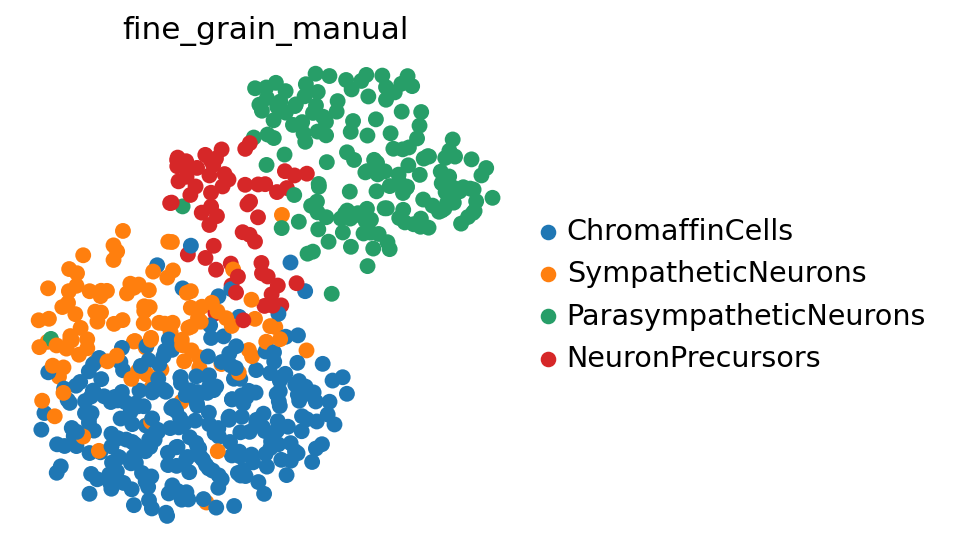

In [28]:
sc.pl.embedding(adata,basis='X_umap',
                color='fine_grain_manual',
                frameon=False,
                wspace=0.3)

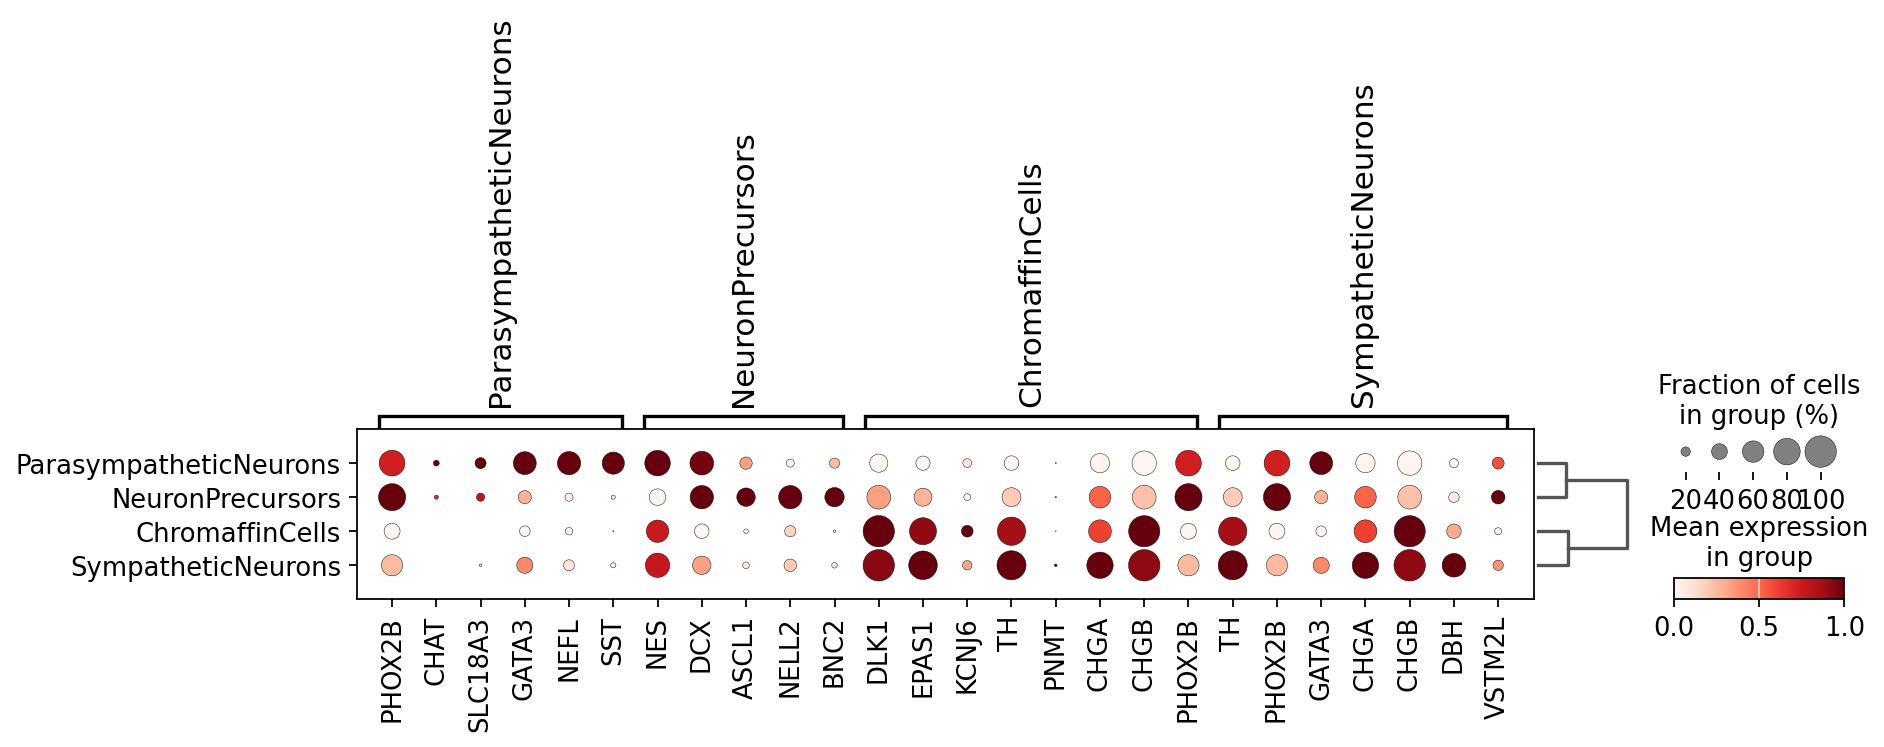

In [33]:
sc.tl.dendrogram(adata,groupby='fine_grain_manual')
sc.pl.dotplot(adata,
              var_names=markers,
              groupby='fine_grain_manual',
              standard_scale='var',
              dendrogram=True
             )

# Save

In [34]:
# save
adata.write(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')
print(f'{adata_dir}/{sample_id}_{celltype}_b2c_cells_filtered_lognorm.h5ad')

/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/subsets/HEA_FOET14880396_Neurons_b2c_cells_filtered_lognorm.h5ad
